In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, Latex
import random
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, ifft, fftfreq


import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ModelWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ModelWarning)
warnings.simplefilter('ignore')


In [37]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# MY_MA

In [64]:
class myMA:
    def __init__(self, c, thetas):
        self.c = c
        self.thetas = thetas
        self.eps = 0.8
        self.burnIn = 0
        self.order = len(thetas)
        self.y = []
        self.y_cut = []
        self.epsilons = None
        self.autoCor = None
        self.pAutoCor = None
        self.name = self.getEquationStr()
        
    def predictMany(self, t): 
        self.y = np.zeros(t)
        self.epsilons = np.random.normal(0, 1, size = t + self.order)

        # set the other elements
        for i in np.arange(0, t):
            self.y[i] = self.c + self.epsilons[i+self.order]
            for j in range(0, self.order):
                self.y[i] += self.epsilons[i + self.order - (j+1)] * self.thetas[j] 
            
        # check autocorrelation
        _, ax = plt.subplots(4, figsize = (20,8))
        #ax[0].set_xlabel('time')
        
        timeCorr = 40#(len(self.y) - 1)//10
        self.autoCor = acf(self.y, nlags = timeCorr, fft = True)
        self.pAutoCor = pacf(self.y, nlags= timeCorr)
        #print(self.pAutoCor)
        # determine burnin
        self.burnin()
    
        plot_acf(self.y, ax=ax[1], lags = timeCorr, fft = True, zero = False)
        plot_pacf(self.y, ax=ax[2], lags = timeCorr)

        ax[0].plot(self.y)
        ax[0].set_title(f'Autoregressive model ${self.name}$ with T={len(self.y)}, burnIn={self.burnIn}')
        ax[3].plot(self.y_cut)
        ax[3].set_title(f'Burnin cut')
        
        
        #self.burnin()
    # http://sbfnk.github.io/mfiidd/mcmc_diagnostics.html#33_burn-in
    def tests(self, data):
        # jung - box - whether we are dealing with white noise
        # with hypothesis of stationary ts we look at p_value - close to one - uncorrelated - up to lags
        jung = acorr_ljungbox(data, lags = [40], return_df=True)
        print("\n\t\t->jung_test (p_value close to 1 -> uncorrelated):\n\n", jung)
        
        # augumented Dickey_Fuller test
        # wheather we are dealing with stationary or not
        fuller = adfuller(data) # timeseries in non-stationary
        print("\n\t\t->adfuller (p_value close to 0 -> stationary):\n\n",fuller)
        # if p value is small - > it is stationary
        
        #kwiatkowski-phillips-s.. test - > hyphothesis is that it is stationary -> p_value high -> stationary
        kp = kpss(data)
        print("\n\t\t->kpss (p_value close to 1 -> stationary):\n\n",kp)
        
    def burnin(self):
       
        print("\n\n\t->test before:")
        self.tests(self.y)
        val = np.exp(-1/self.eps)
        for i in range(len(self.autoCor)):
            autocor = abs(self.autoCor[i])    
            #print(autocor)
            if autocor < val:
                self.burnIn = i
                break
        self.y_cut = self.y[self.burnIn:-1]
        print("\n\n\t->test after:")
        self.tests(self.y_cut)
        print(f'\n\t->Burnin parameter is {self.burnIn}')
    
    def getEquationStr(self):
        eq = f'y_t={self.c}'
        inside = str([f'{"+" if val > 0 else ""}{val:.2f}'+'y_{t-%s}'%(str(t+1)) for t, val in enumerate(self.thetas)]).replace('\'[]','')
        for k in ['\'', '[', ']']:
            inside = inside.replace(k,'')
        eq += inside
        eq += '+e_t'
        display(Latex(f" --------------------------------- Doing AR({len(self.y)}): ${eq}$ --------------------------------- "))
        return  eq


## first 0.8

<IPython.core.display.Latex object>



	->test before:

		->jung_test (p_value close to 1 -> uncorrelated):

         lb_stat      lb_pvalue
40  1248.567212  8.272511e-236

		->adfuller (p_value close to 0 -> stationary):

 (-18.240737823678348, 2.3552827517304848e-30, 14, 4985, {'1%': -3.4316624715142177, '5%': -2.862119970102166, '10%': -2.5670787188546584}, 14075.074531407974)

		->kpss (p_value close to 1 -> stationary):

 (0.1067282649779246, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


	->test after:

		->jung_test (p_value close to 1 -> uncorrelated):

         lb_stat      lb_pvalue
40  1249.307702  5.777318e-236

		->adfuller (p_value close to 0 -> stationary):

 (-18.245881811059668, 2.349048983173022e-30, 14, 4982, {'1%': -3.4316632622500816, '5%': -2.8621203194445384, '10%': -2.5670789048233216}, 14067.025030903353)

		->kpss (p_value close to 1 -> stationary):

 (0.10044307319464742, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

	->Burnin parameter is 2


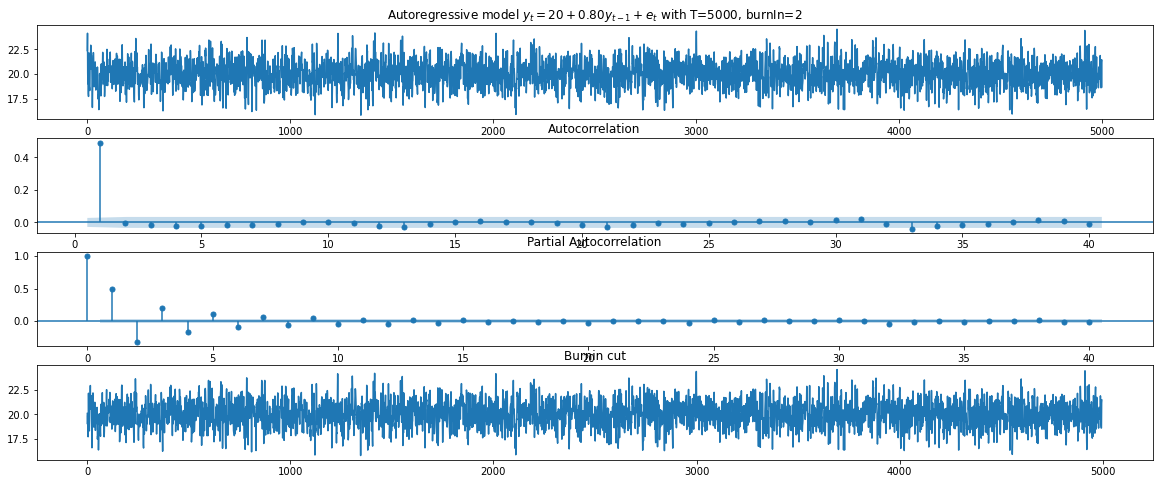

In [65]:

c = 20
phi = [0.8]
a = myMA(c, phi)
a.predictMany(5000)


## second -1, 0.8

<IPython.core.display.Latex object>



	->test before:

		->jung_test (p_value close to 1 -> uncorrelated):

         lb_stat  lb_pvalue
40  2903.747019        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-12.970216768261565, 3.092448677492304e-24, 28, 4971, {'1%': -3.431666169784722, '5%': -2.862121603975143, '10%': -2.567079588629541}, 14127.1437833252)

		->kpss (p_value close to 1 -> stationary):

 (0.04488214866944349, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


	->test after:

		->jung_test (p_value close to 1 -> uncorrelated):

         lb_stat  lb_pvalue
40  2903.529099        0.0

		->adfuller (p_value close to 0 -> stationary):

 (-12.845260355869103, 5.497567861341495e-24, 28, 4967, {'1%': -3.4316672302646283, '5%': -2.8621220724882153, '10%': -2.5670798380375506}, 14119.041268320798)

		->kpss (p_value close to 1 -> stationary):

 (0.0437708406815965, 0.1, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

	->Burnin parameter is 3


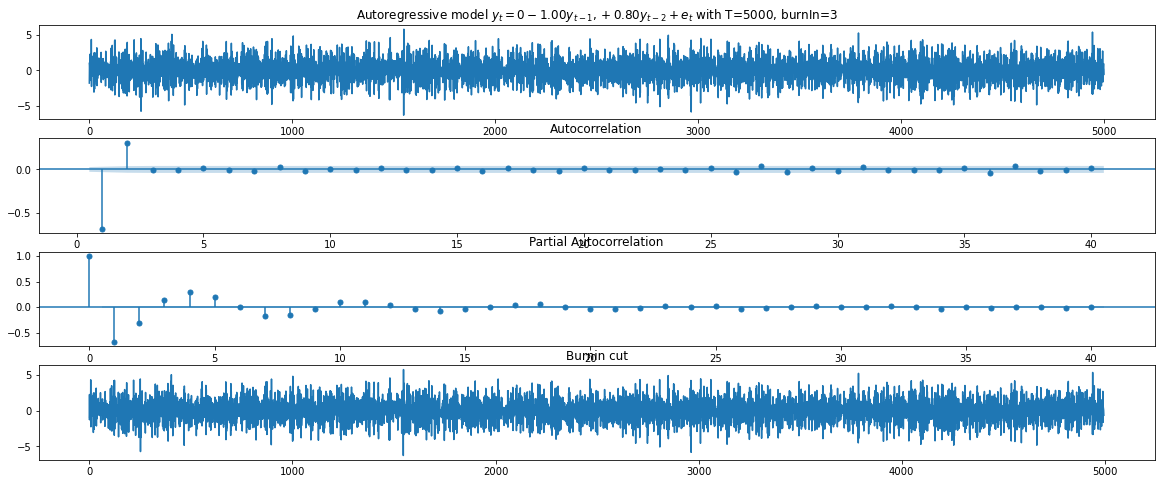

In [66]:

c = 0
phi = [-1, 0.8]
a = myMA(c, phi)
a.predictMany(5000)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5000
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7097.369
Date:                Tue, 26 Apr 2022   AIC                          14202.739
Time:                        08:17:17   BIC                          14228.807
Sample:                             0   HQIC                         14211.875
                               - 5000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.011      0.116      0.908      -0.021       0.023
ma.L1         -1.0081      0.009   -115.320      0.000      -1.025      -0.991
ma.L2          0.7994      0.008     94.723      0.000       0.783       0.816
sigma2         1.0006      0.021     48.498      0.000       0.960       1.041
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.54
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               0.96   Skew:                            -0.05
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

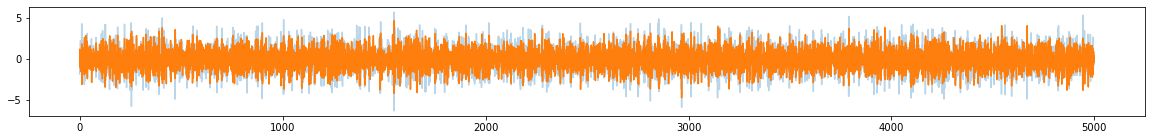

In [81]:
model = ARIMA(a.y, order = (0, 0, 2))
results = model.fit()
pred = results.predict(dynamic = False)

_, ax = plt.subplots(1, figsize = (20,2))
ax.plot(a.y, alpha = 0.3)
ax.plot(pred)
results.summary()

# AR FORECASTING

In [3]:
from statsmodels.tsa.ar_model import AR, ARResults
def printAR(fit):
    print(f'Lag:\n\t{fit.k_ar}\ncoeff:\n{fit.params}')
    
def reverseDiff(df, diff, column, shift = 1):
    x, x_diff = df[column].iloc[0], diff.iloc[shift:]
    return pd.Series(np.r_[x, x_diff].cumsum())

shift = 1
maxlag = 20

In [390]:
robusta = pd.read_html('https://www.indexmundi.com/commodities/?commodity=robusta-coffee&months=240')
robustaDF = robusta[1]
robustaDF['Month'] = pd.to_datetime(robustaDF['Month'])
robustaDF.set_index(['Month'], inplace = True)
robustaDF

,Price,Change
Month,,
2002-03-01,0.64,-
2002-04-01,0.65,1.56%
2002-05-01,0.62,-4.62%
2002-06-01,0.63,1.61%
2002-07-01,0.63,0.00%
...,...,...
2021-09-01,2.31,10.00%
2021-10-01,2.32,0.43%
2021-11-01,2.41,3.88%


## Train-Test split

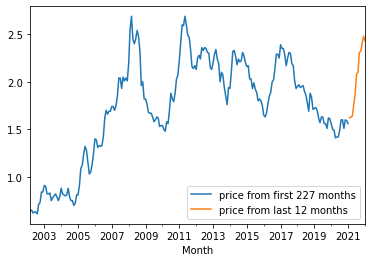

In [391]:
forecastLen = 12
trainLen = len(robustaDF)-forecastLen

trainRobusta = robustaDF.iloc[:trainLen]
testRobusta = robustaDF.iloc[trainLen:]
trainRobusta.columns = [f'price from first {len(robustaDF)-forecastLen} months', 'Change']
testRobusta.columns = [f'price from last {forecastLen} months', 'Change']
ax = trainRobusta.plot()
testRobusta.plot(ax=ax, label = f'last {forecastLen} months', legend = True)


columnTrain = trainRobusta.columns[0]
columnTest = testRobusta.columns[0]

## Non-differenced data

Lag:
	20
coeff:
const                              0.024078
L1.price from first 227 months     1.250700
L2.price from first 227 months    -0.263838
L3.price from first 227 months     0.008547
L4.price from first 227 months     0.006578
L5.price from first 227 months     0.012330
L6.price from first 227 months    -0.012362
L7.price from first 227 months    -0.064562
L8.price from first 227 months     0.066119
L9.price from first 227 months     0.042034
L10.price from first 227 months   -0.062886
L11.price from first 227 months   -0.069081
L12.price from first 227 months    0.064803
L13.price from first 227 months    0.014477
L14.price from first 227 months    0.087147
L15.price from first 227 months   -0.233665
L16.price from first 227 months    0.083275
L17.price from first 227 months    0.141037
L18.price from first 227 months   -0.160210
L19.price from first 227 months    0.172394
L20.price from first 227 months   -0.098393
dtype: float64
The accuracy is - mse = 0.3790813009420537


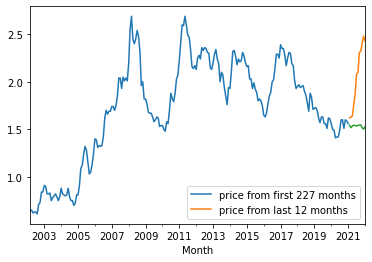

In [392]:
modelNon = AR(trainRobusta[columnTrain])
# fit
fitNon = modelNon.fit(maxlag = maxlag, method = 'mle')
printAR(fitNon)
# predict
start = len(trainRobusta)
end = len(trainRobusta) + len(testRobusta) - 1
predNon = fitNon.predict(start = start, end = end, dynamic = False).rename('Non differenced data')

ax = trainRobusta.plot()
testRobusta.plot(ax=ax)
predNon.plot(ax=ax)
accNon = mean_squared_error(testRobusta[columnTest].to_numpy(), predNon.to_numpy())
print(f"The accuracy is - mse = {accNon}")

## Differenced data

### check the autocorrelation


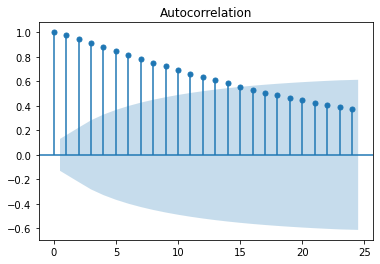

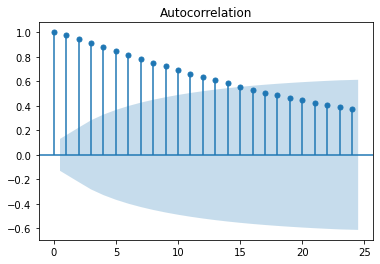

In [393]:
plot_acf(trainRobusta[columnTrain])

### create difference

Month
2002-04-01    0.01
2002-05-01   -0.03
2002-06-01    0.01
2002-07-01    0.00
2002-08-01   -0.02
              ... 
2020-09-01    0.00
2020-10-01   -0.09
2020-11-01    0.09
2020-12-01   -0.01
2021-01-01   -0.03
Name: price from first 227 months, Length: 226, dtype: float64

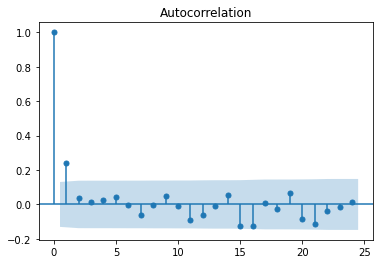

In [394]:
trainRobustaDiff = trainRobusta[columnTrain].diff(shift).dropna()
plot_acf(trainRobustaDiff)
trainRobustaDiff

### fit again

In [397]:
model = AR(trainRobustaDiff.to_numpy())
# fit
fit = model.fit(maxlag = maxlag, method = 'mle')
printAR(fit)
# predict
start = len(trainRobustaDiff) #+ diff
end = len(trainRobustaDiff) + len(testRobusta) - 1
pred = fit.predict(start = start, end = end, dynamic = False)
pred = pd.Series(pred, index = testRobusta.index)

fullDifferencedPred = trainRobusta[columnTrain].diff(shift).append(pred, ignore_index=True)
# return to non-differenced data
diffBack = reverseDiff(trainRobusta, trainRobusta[columnTrain].diff(shift), columnTrain, shift)
predReal = reverseDiff(trainRobusta, fullDifferencedPred, columnTrain, shift)

full = pd.DataFrame(columns=['real','diff', 'back'])
full['diff'] = trainRobustaDiff
full['real'] = trainRobusta[columnTrain].iloc[shift:]
full['back'] = diffBack.iloc[shift:].to_numpy()

#"print(predReal)
predReal = pd.Series(predReal[shift:].to_numpy(), index = robustaDF.index[1:])
predRealTest = pd.DataFrame(columns=['pred','real'])
predRealTest['differenced'] = predReal.to_numpy()
predRealTest['real'] = robustaDF['Price'].iloc[shift:].to_numpy()
predRealTest.index = robustaDF.index[shift:]
predRealTest 


Lag:
	20
coeff:
[ 0.00373972  0.26837138 -0.01840859  0.00919475 -0.00051124  0.0018554
  0.01896558 -0.05591133  0.00854913  0.04430708 -0.01044202 -0.07185736
 -0.01494307 -0.00477558  0.08858318 -0.14371465 -0.0616476   0.07925602
 -0.08342745  0.12026067 -0.11652976]


,pred,real,differenced
Month,,,
2002-04-01,NaN,0.65,0.650000
2002-05-01,NaN,0.62,0.620000
2002-06-01,NaN,0.63,0.630000
2002-07-01,NaN,0.63,0.630000
2002-08-01,NaN,0.61,0.610000
...,...,...,...
2021-09-01,NaN,2.31,1.582145
2021-10-01,NaN,2.32,1.596471
2021-11-01,NaN,2.41,1.572697


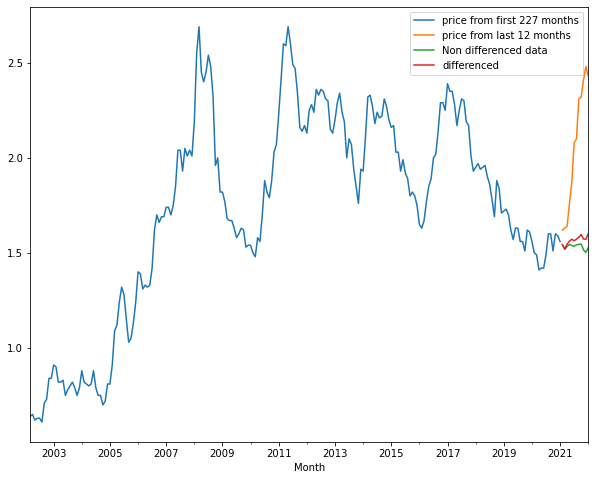

The accuracy is - mse = 0.3790813009420537


In [398]:

# compare all predictions
fig, ax = plt.subplots(1, figsize = (10,8))
# plot just the training
trainRobusta[columnTrain].plot(ax = ax)
# plot real data from last part
testRobusta[columnTest].plot(ax = ax)
#ax.plot(testRobusta.index, np.array(testRobusta[columnTest]), label = 'original data')
# plot non-differenced prediction
predNon.plot(ax=ax)
# plot differenced prediction
#ax.plot(testRobusta.index, predNon.diff(), label = 'non-differenced data predicted')
predRealTest.iloc[trainLen-shift:]['differenced'].plot(ax=ax)
#ax.plot(testRobusta.index, pred, label = 'differenced data predicted')
ax.legend()
plt.show()

#accNon = mean_squared_error(testRobusta[columnTest].diff().to_numpy(), predNon.to_numpy())
print(f"The accuracy is - mse = {accNon}")
#testRobusta.index, pred

# TRY IT WITH ARIMA MODEL

<AxesSubplot:xlabel='DATE'>

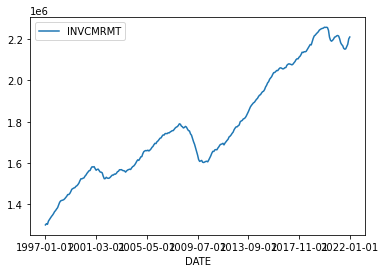

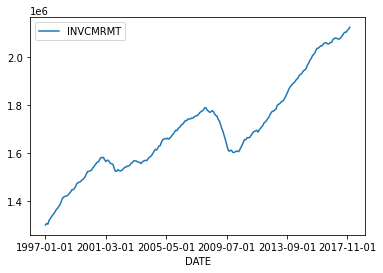

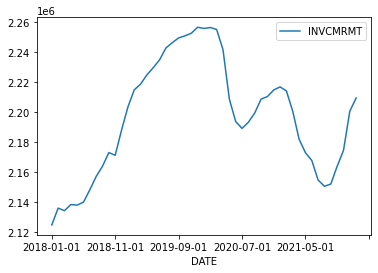

In [70]:
df = pd.read_csv('INVCMRMT.csv', parse_dates = True)
df = df.set_index('DATE')
df.plot()

# set the dates
timestart = datetime.datetime(1997,1,1)
timeend = datetime.datetime(2018,1,1)
df_train = df.loc['1997-01-01':'2018-01-01']
df_train.plot()
df_test = df.loc['2018-01-01':]
df_test.plot()

In [27]:
df_test

,INVCMRMT
DATE,
2018-01-01,2124655.0
2018-02-01,2135865.0
2018-03-01,2134146.0
2018-04-01,2138236.0
2018-05-01,2137865.0
2018-06-01,2139842.0
2018-07-01,2148096.0
2018-08-01,2156969.0
2018-09-01,2163820.0


In [71]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ModelWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ModelWarning)
warnings.simplefilter('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
auto_arima(df, seasonal = False, m = 2, trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6202.069, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6163.739, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6239.111, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6169.342, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6213.779, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6209.402, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.474 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  301
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3079.870
Date:                Tue, 26 Apr 2022   AIC                           6163.739
Time:                        08:13:02   BIC                           6171.147
Sample:                             0   HQIC                          6166.704
                                - 301                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3027.1567    478.019      6.333      0.000    2090.258    3964.056
sigma2      4.838e+07   2.86e+06     16.941      0.000    4.28e+07     5.4e+07
===================================================================================
Ljung-Box (L1) (Q):                 117.91   Jarque-Bera (JB):               226.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -1.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
model = ARIMA(df_train, order = (0, 0, 2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               INVCMRMT   No. Observations:                  253
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -3321.590
Date:                Tue, 26 Apr 2022   AIC                           6651.181
Time:                        08:12:31   BIC                           6665.314
Sample:                    01-01-1997   HQIC                          6656.867
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.697e+06   1.68e+05     10.118      0.000    1.37e+06    2.03e+06
ma.L1          1.7630      0.656      2.689      0.007       0.478       3.048
ma.L2          0.8883      0.662      1.341      0.180      -0.410       2.187
sigma2      3.617e+10      0.068   5.32e+11      0.000    3.62e+10    3.62e+10
===================================================================================
Ljung-Box (L1) (Q):                 203.44   Jarque-Bera (JB):                 3.72
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               1.39   Skew:                             0.28
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.62e+28. Standard errors may be unstable.
"""

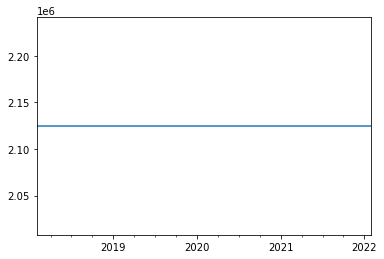

In [36]:
start = len(df_train)
end = start + len(df_test) - 1
predictions = results.predict(start = start, end = end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)(0,0,0,2)')
ax = predictions.plot()
#df_train.plot(ax=ax)
#df_test.plot(ax=ax)
#mean_absolute_percentage_error(df_test, predictions)